# Import networks

for gating, keeping 100% of networks
for inversion, keeping 100% of networks
for reshuffle, keeping 100% of networks
for notricks, keeping 100% of networks
for backprop_la0, keeping 100% of networks
for backprop_la4, keeping 100% of networks
for backprop_lashort, keeping 100% of networks


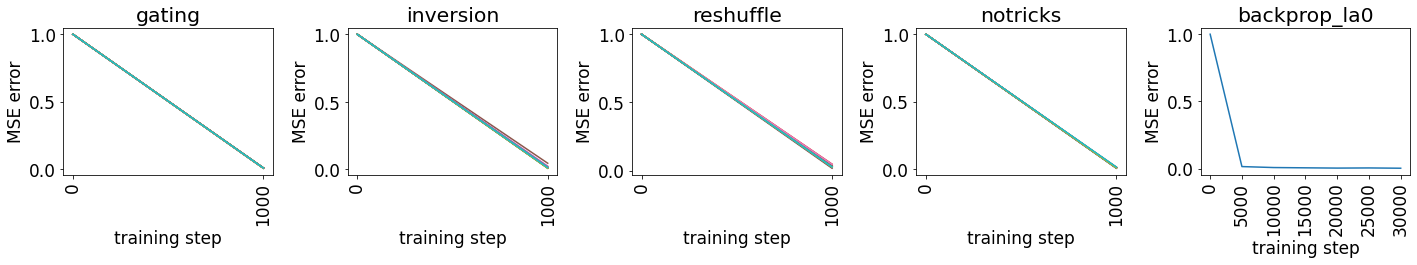

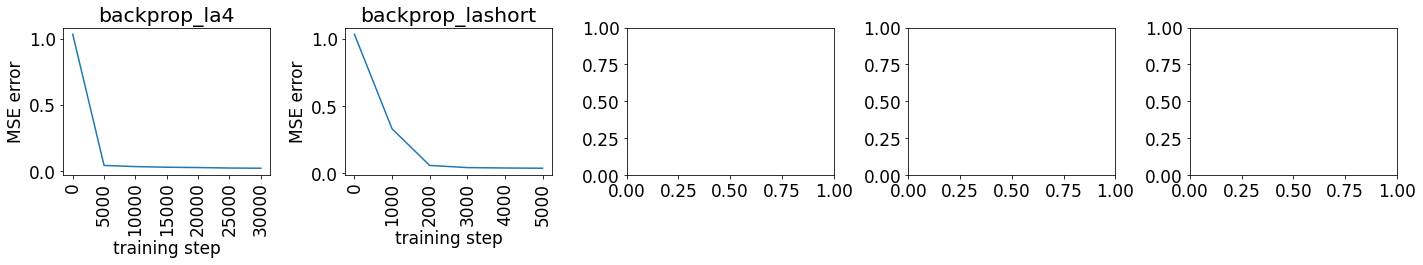

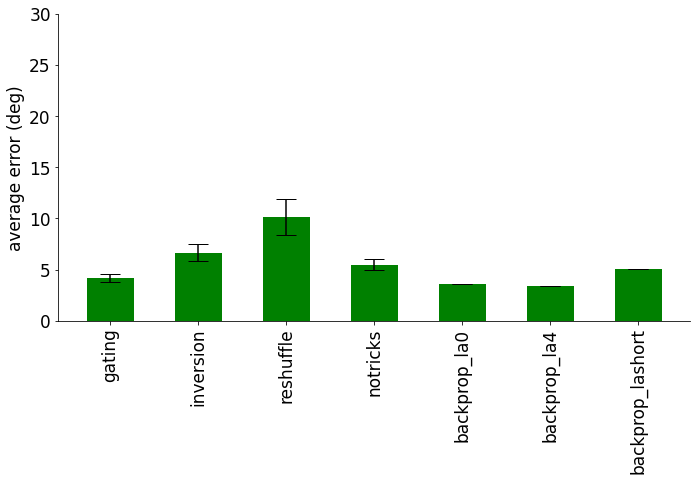

In [54]:
import numpy as np
from netrep.metrics import LinearMetric
from netrep.metrics import GaussianStochasticMetric
import matplotlib.pyplot as plt
import seaborn as sns
import json, math
from scipy import stats

# Load all networks to study here
all_networks = {
    "gating": {
        "color": "green",  # color of dots on the graph
        "names": [f"data/hdgatingCTRNN_2DIR1O_dr100_n0.1_la0_r{i}_dv" for i in range(20)],  # directories
        "indices": np.arange(0, 64, 16)  # indices of trials to consider (here, only using 4 trials to match neural data)
    },
    "inversion": {
        "color": "red",
        "names": [f"data/hdinversionCTRNN_2DIR1O_dr100_n0.1_la0_r{i}_dv" for i in range(20)],
        "indices": np.arange(0, 64, 16)
    },
    "reshuffle": {
        "color": "blue",
        "names": [f"data/hdreshuffleCTRNN_2DIR1O_dr100_n0.1_la0_sa130_r{i}_dv" for i in range(20)],
        "indices": np.arange(0, 64, 16)
    },
    "notricks": {
        "color": "yellow",  # random color
        "names": [f"data/hdnotricksCTRNN_2DIR1O_dr100_n0.1_la0_r{i}_dv" for i in range(20)],
        "indices": np.arange(0, 64, 16)
    },
    "backprop_la0": {
        "color": np.random.rand(3,),  # random color
        "names": [f"data/backpropnpCTRNN_2DIR1O_dr100_n0.1_la0_dp0.5_rAA" for i in range(1)],
        "indices": np.arange(0, 64, 16)
    },
    "backprop_la4": {
        "color": np.random.rand(3,),  # random color
        "names": [f"data/backpropCTRNN_2DIR1O_dr100_n0.1_la0.0001_dp1.0_rAA" for i in range(1)],
        "indices": np.arange(0, 64, 16)
    },
    "backprop_lashort": {
        "color": np.random.rand(3,),  # random color
        "names": [f"data/backpropCTRNN_2DIR1O_dr100_n0.1_la0.0001_dp1.0_rSHORT" for i in range(1)],
        "indices": np.arange(0, 64, 16)
    },
    "diego_phd_mst": {
        "color": "orange",
        "names": ["neuraldata/new/diego_phd_mst_both_selective_zscored"],
        "indices": np.array([0, 1, 2, 3]),
        "neural": True
    },
    "diego_new_mst": {
        "color": np.random.rand(3,),
        "names": ["neuraldata/new/diego_new_mst_both_selective_zscored"],
        "indices": np.array([0, 1, 2, 3]),
        "neural": True
    }
}


#keep = "gating,inversion,reshuffle120,inv+gat,backpropnd0,backproprd0,backproprde-4,backpropndWCe-3,backpropnp,notricks,diego_phd_mst,diego_phd_pfc,diego_new_mst,diego_new_pfc,cheng_pfc".split(',')
#keep = "gating,inversion,reshuffle120,inv+gat,backpropnd0,backproprd0,backproprde-4,backpropndWCe-3,backpropnp,backpropnpsde-4,notricks,diego_phd_mst,diego_phd_pfc,diego_new_mst,diego_new_pfc,cheng_pfc".split(',')
#for key in list(all_networks.keys()):
#   if key not in keep: del all_networks[key]
       
# neural data not available

# load information about every network
for network in all_networks.values():
    if "neural" in network: continue
    network["errors"] = []
    network["metadatas"] = []
    for name in network["names"]:
        with open(name+"/info.json") as f: info = json.load(f)
        network["errors"].append(info["errors_last"][2])
        network["metadatas"].append(info)

# filter to only use the networks where MSE < 15 deg (only those that converged)
for name, network in all_networks.items():
    if 'errors' in network:
        indices_to_remove = []
        for i, error in enumerate(network['errors']):
            if error>15 or math.isnan(error):
                indices_to_remove.append(i)
                
        print(f"for {name}, keeping {int((1-len(indices_to_remove)/len(network['names']))*100)}% of networks")
        if False:
            for x in indices_to_remove[::-1]:
                del network['names'][x]
                del network['errors'][x]
                del network['metadatas'][x]
            #print([i for i in range(20) if i not in indices_to_remove])

# show all errors through time, for an overview
row_count = 0  # Counter to track the number of plots in the current row
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Create a row of 5 subplots
for network_name, network in all_networks.items():
    if "neural" in network: continue
    ax = axs[row_count]  # Select the subplot
    for name in network["names"]:
        with open(name+"/info.json") as f: 
            info = json.load(f)
        ax.plot(list(info["error_store_saved"].keys()), list(info["error_store_saved"].values()))
    ax.set_title(network_name)
    ax.set_xlabel("training step")
    ax.set_ylabel("MSE error")
    for label in ax.get_xticklabels(): label.set_rotation(90)
    row_count += 1
    if row_count >= 5:  # Reset if 5 plots in a row
        plt.tight_layout()
        plt.show()
        fig, axs = plt.subplots(1, 5, figsize=(20, 4))
        row_count = 0
plt.tight_layout()
plt.show()

# show all final errors of kept networks, for comparison
use_networks = [key for key in all_networks.keys() if "neural" not in all_networks[key] or not all_networks[key]["neural"]]
means = [np.mean(all_networks[network]["errors"]) for network in use_networks]
errors = [np.std(all_networks[network]["errors"]) for network in use_networks]
fig = plt.figure(figsize=(10, 7))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
ax = plt.subplot(1, 1, 1)
ax.bar(np.arange(1, len(use_networks)+1)*1.5, means, yerr=errors, align='center', alpha=1, ecolor='black', capsize=10, color="green")
plt.xticks(ticks=np.arange(1, len(use_networks)+1)*1.5, labels=use_networks)
plt.ylim(0, 30)
ax.set_ylabel('average error (deg)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

# Load and normalize firing rates

In [72]:
def normalization_function(firing_rates, smoothing_term=0.05):
    mean_fr = np.expand_dims(np.mean(temp, axis=0), axis=0)
    std_fr = np.expand_dims(np.std(temp, axis=0), axis=0)
    return (firing_rates - mean_fr)/(std_fr+smoothing_term)+1
    
    min_fr = np.expand_dims(np.min(temp, axis=0), axis=0)
    max_fr = np.expand_dims(np.max(temp, axis=0), axis=0)
    return (firing_rates-min_fr) / (max_fr-min_fr+smoothing_term)    
    
arrays = []
network_names = []
i = 0
for network_name, network in all_networks.items():
    names = network["names"]
    if "neural" in network:  # process neural data separately, as it's in a different format.
        for name in names:
            temp = np.load(name+".npy").reshape(4, 2, -1)+10
            #temp = normalization_function(temp, smoothing_term=1)
            temp = temp.reshape(-1, temp.shape[-1])
            arrays.append(temp)
    else:
        for j, name in enumerate(names):
            # defining parameters (these have to be the same as in training files)
            n_trials = 64
            net_size = 100
            input_time = 10
            delay0, delay1, delay2 = (15, 90, 140)
            total_time = delay0+delay2+input_time+100
            t_cue_from = delay0
            t_cue_to = delay0+input_time
            t_d_from = delay0+input_time+20  # remove first 200 ms of delay
            t_d_to = delay0+input_time+delay1
            
            model_parameterupdate = network['metadatas'][j]['hyperparameters']['train_for_steps']
            if "SHORT" in name: model_parameterupdate = 2000
            array = np.load(name+f"/model_parameterupdate{model_parameterupdate}_fr.npy")
            temp = np.zeros((n_trials, 2, net_size))
            temp[:, 0, :] = np.mean(array.reshape(n_trials, total_time, net_size)[::, t_cue_from:t_cue_to, :], axis=1)
            temp[:, 1, :] = np.mean(array.reshape(n_trials, total_time, net_size)[::, t_d_from:t_d_to, :], axis=1)
            temp = normalization_function(temp, smoothing_term=0.01)
            temp = temp[network["indices"]]  # only select certain trials
            temp = temp.reshape(-1, net_size)
            arrays.append(temp)
            
    network_names.append(network_name)
    network['ids'] = []
    for name in names:
        network['ids'].append(i)
        i+=1

## Visualize firing rates of neurons after normalization

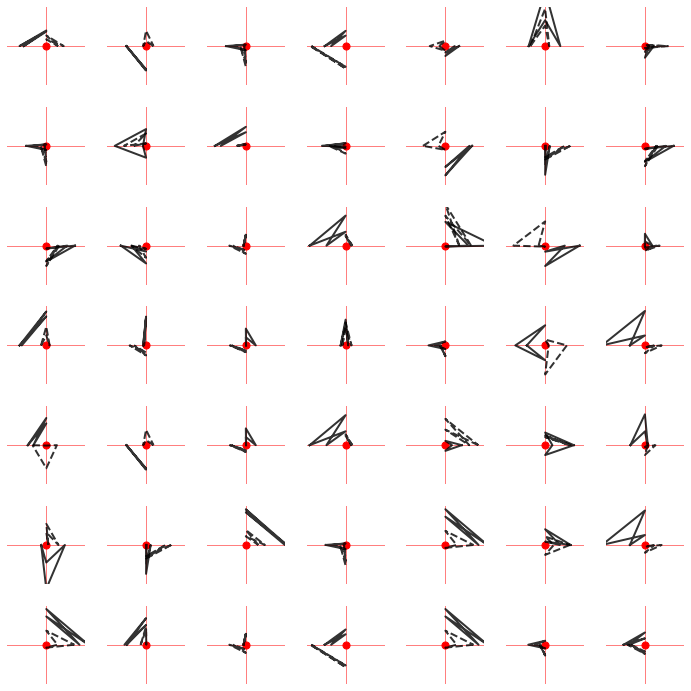

In [63]:
# visualize how selective neurons look like after normalization
# solid line for t=input, dotted for t=distractor
show_neurons = "diego_phd_mst"
#show_neurons = "gating"
array = np.copy(arrays[all_networks[show_neurons]["ids"][0]].reshape(4, 2, -1))
fig, axes = plt.subplots(7, 7, figsize=(10, 10))
for i in range(7):
    for j in range(7):
        ax = axes[i, j]
        n_i = 5 * i + j
        n_i = np.random.randint(0, array.shape[-1]-1)#5 * i + j
        
        ax.scatter([0], [0], 50, color="red")
        ax.plot([-100, 100], [0, 0], "r-", linewidth=.5)
        ax.plot([0, 0], [-100, 100], "r-", linewidth=.5)

        coords = np.array([[1, 0], [0, 1], [-1, 0], [0, -1], [1, 0]], dtype=float)
        coords *= np.expand_dims(array[:, 0, n_i][[0, 1, 2, 3, 0]], axis=1)
        ax.plot(coords[:, 0], coords[:, 1], "k-", linewidth=2, alpha=0.8)

        coords = np.array([[1, 0], [0, 1], [-1, 0], [0, -1], [1, 0]], dtype=float)
        coords *= np.expand_dims(array[:, 1, n_i][[0, 1, 2, 3, 0]], axis=1)
        ax.plot(coords[:, 0], coords[:, 1], "k--", linewidth=2, alpha=0.8)

        lim = 1
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.axis('off')
plt.tight_layout()
plt.show()

N_neurons = 100


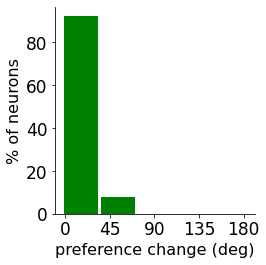

In [76]:
show_neurons = "notricks"
#show_neurons = "gating"
array = np.copy(arrays[all_networks[show_neurons]["ids"][0]].reshape(4, 2, -1))

thetas = np.array([0, 90, 180, 270]) / 180 * np.pi
thetas = np.expand_dims(thetas, 1)
thetas = np.expand_dims(thetas, 1)
cn = np.sum(np.exp(1j*thetas)*array, axis=0)/np.sum(array, axis=0)
pref = np.angle(cn)

pref_angle_diff = np.copy(pref[0]-pref[1]) / np.pi * 180
pref_angle_diff = np.abs(pref_angle_diff)
pref_angle_diff[pref_angle_diff>180] = 360 - pref_angle_diff[pref_angle_diff>180]
pref_angle_diff = pref_angle_diff[:]

fig = plt.figure(figsize=(4, 4))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
ylim = 99
ax = fig.add_subplot(1, 1, 1)
bins = 5

# Replacing torch.histc with numpy.histogram
hist, edges = np.histogram(pref_angle_diff, bins=bins, range=(0, 180))
hist = hist.astype(float) / np.sum(hist)

x = np.linspace(0, 180, bins, endpoint=False)  # Generate bin centers
if bins==5: x = x*1.033+16  # make the bars align
if bins==7: x = x*1.033+10
ax.bar(x, hist*100, align='center', width=180/bins/1.05, color="green")


ax.set_xlabel('preference change (deg)', fontsize=16)
ax.set_ylabel('% of neurons', fontsize=16)
ax.set_xticks(np.arange(0, 181, 45))
#ax.set_ylim(0, ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
print(f"N_neurons = {len(pref_angle_diff)}")
plt.show()

# Calculate distance matrix and run tSNE

Parallelizing 3570 distance calculations with 12 processes.


Computing distances: 100%|█████████████████| 3570/3570 [00:06<00:00, 592.93it/s]


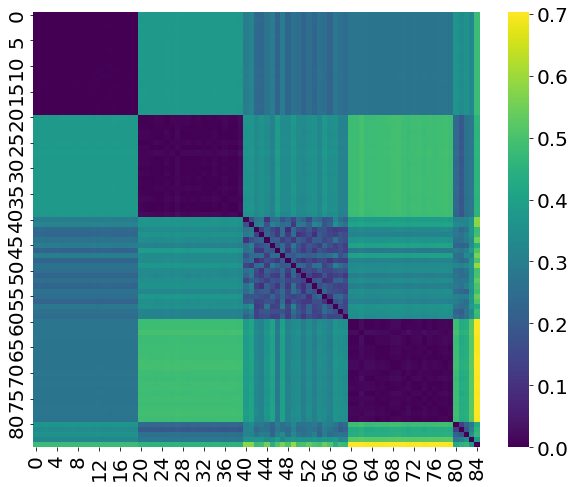

/var/folders/47/5g669ycs2t17c0kkg2_np43m0000gn/T/ipykernel_37190/35068407.py:22: RuntimeWarning: Mean of empty slice
  dist_ave[i, j] = np.nanmean(temp)


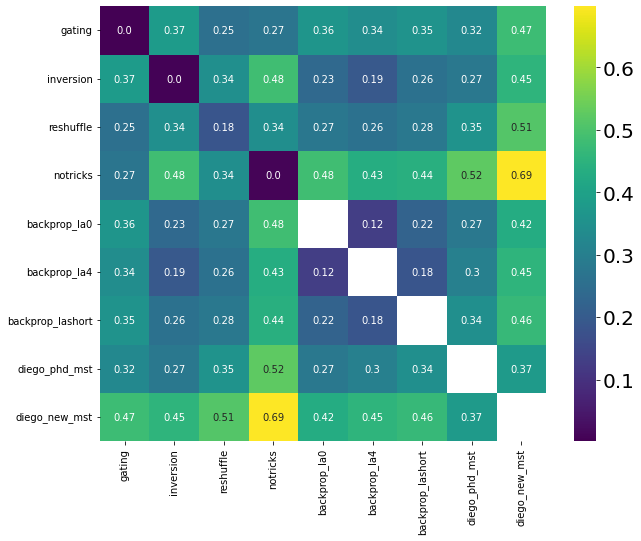

In [74]:
# calculating distances between networks
metric = LinearMetric(alpha=1.0, zero_pad=True)
dist = metric.pairwise_distances(arrays)[0]

labels_once = list(all_networks.keys())
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 20})
fig = plt.figure(figsize=(10, 8))
ax = sns.heatmap(dist, cmap="viridis")
plt.show()

fig = plt.figure(figsize=(10, 8))
n_networks = len(labels_once)
dist_ave = np.zeros((n_networks, n_networks))
for i in range(n_networks):
    for j in range(n_networks):
        temp = np.copy(dist[list(all_networks.values())[i]['ids'], :][:, list(all_networks.values())[j]['ids']])
        if i==j: 
            for k in range(len(temp)):
                temp[k, k] = None # remove diagonal elemenrs
        #print(i, j, temp)
        #print(list(networks.values())[i]['ids'], list(networks.values())[j]['ids'])
        dist_ave[i, j] = np.nanmean(temp)
ax = sns.heatmap(dist_ave, cmap="viridis", annot=((dist_ave*100).astype(int)/100).astype(str), annot_kws={'fontsize': 10}, fmt='s')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xticks(np.linspace(0.5, len(labels_once)-.5, len(labels_once)), labels_once, fontsize=10)
plt.yticks(np.linspace(0.5, len(labels_once)-.5, len(labels_once)), labels_once, fontsize=10)
plt.show()

Perplexity value 500 is too high. Using perplexity 28.00 instead


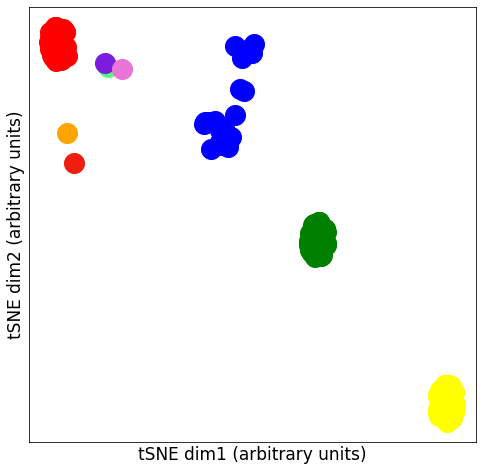

In [75]:
import openTSNE
tsne = openTSNE.TSNE(
    perplexity=500,  # always use maximum possible perplexity, to preserve global structure
    metric='precomputed',
    verbose=False,
    initialization='spectral',
)

include = "gating,inversion,reshuffle,notricks,backprop_la0,diego_phd_mst,diego_new_mst".split(',')
include = all_networks.keys()
ids = np.concatenate([all_networks[name]['ids'] for name in include])
embedding = tsne.fit(dist[ids, :][:, ids])
fig = plt.figure(figsize=(8, 8))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
i = 0
for name, network in all_networks.items():
    if name not in include: continue
    n = len(network['ids'])
    plt.scatter(embedding[i:i+n, 0], embedding[i:i+n, 1], 400, color=network['color'], label=name)
    i += n
plt.xlabel("tSNE dim1 (arbitrary units)")
plt.ylabel("tSNE dim2 (arbitrary units)")
plt.xticks([])
plt.yticks([])
#plt.xlim(-8, 8)
#plt.ylim(-6, 3)
#plt.legend()
#plt.gca().axis('off')
plt.savefig("tSNE.pdf", bbox_inches = 'tight')

## Try to embed new points into an existing space (not working yet)

Perplexity value 500 is too high. Using perplexity 38.33 instead


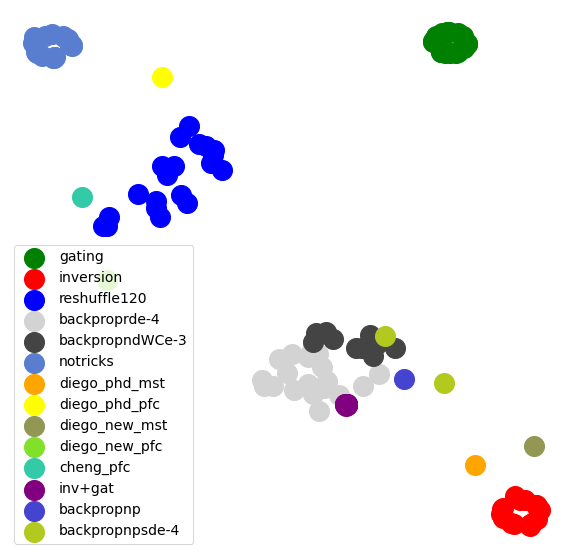

In [30]:
include_new = "diego_phd_mst,diego_phd_pfc,diego_new_mst,diego_new_pfc,cheng_pfc".split(',')
include_new = "inv+gat,backpropnp,backpropnpsde-4".split(',')
ids_new = np.concatenate([all_networks[name]['ids'] for name in include_new])
embedding_new = embedding.transform(dist[ids[:], :][:, ids_new].T, perplexity=500, exaggeration=1)
fig = plt.figure(figsize=(10, 10))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
i = 0
for name, network in all_networks.items():
    if name not in include: continue
    n = len(network['ids'])
    plt.scatter(embedding[i:i+n, 0], embedding[i:i+n, 1], 400, color=network['color'], label=name)
    i += n
i = 0
for name, network in all_networks.items():
    if name not in include_new: continue
    n = len(network['ids'])
    plt.scatter(embedding_new[i:i+n, 0], embedding_new[i:i+n, 1], 400, color=network['color'], label=name)
    i += n
plt.xlabel("openTSNE dim1")
plt.ylabel("openTSNE dim2")
plt.legend()
plt.gca().axis('off')
plt.show()#plt.savefig("ccn_opentsne.pdf", bbox_inches = 'tight')

# Display firing rates

data/hdgatingCTRNN_2DIR1O_dr100_n0.1_la0_r5_dv


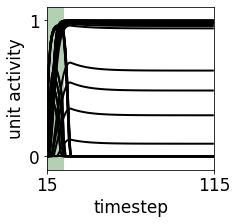

In [36]:
import matplotlib.patches as mpatches

network = all_networks["inversion"]
network = all_networks["gating"]
j = 5
n_trials = 64
net_size = 100

name = network['names'][j]
print(name)
t_from, t_to = delay0, delay0+input_time+delay1
array = np.load(name+f"/model_parameterupdate{network['metadatas'][j]['hyperparameters']['train_for_steps']}_fr.npy")
array = array.reshape(n_trials, 265, net_size)
fig = plt.figure(figsize=(3, 3))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
for i in range(0, net_size, 6):
    plt.plot(array[0::16, 0:t_to, i].T, linewidth=2, color="k", alpha=1)
plt.gca().axvspan(t_from, t_from+input_time, facecolor="darkgreen", alpha=0.3)
plt.xlim(t_from, t_to)
plt.xticks((t_from, t_to))
plt.ylim(-0.1, 1.1)
plt.yticks([0,1])
plt.xlabel("timestep")
plt.ylabel("unit activity")
plt.savefig(f"firingrates{j}.pdf", bbox_inches = 'tight')

# Statistical tests between clusters

In [403]:
neuraldata_name = "diego_phd_mst"
comparison_cluster1 = "backproprde-4"
comparison_cluster2 = "backpropnd0"

dist_1 = dist[all_networks[neuraldata_name]['ids'], :][:, all_networks[comparison_cluster1]['ids']][0]
dist_2 = dist[all_networks[neuraldata_name]['ids'], :][:, all_networks[comparison_cluster2]['ids']][0]

t_stat, p_value = stats.ttest_ind(dist_1, dist_2, alternative='two-sided')
print(f"distances {neuraldata_name}<->{comparison_cluster1}: {np.mean(dist_1):.3f} +- {stats.sem(dist_1):.3f} (N={len(all_networks[comparison_cluster1]['ids'])})")
print(f"distances {neuraldata_name}<->{comparison_cluster2}: {np.mean(dist_2):.3f} +- {stats.sem(dist_2):.3f} (N={len(all_networks[comparison_cluster2]['ids'])})")
print(f"P = {p_value}")

distances diego_phd_mst<->backproprde-4: 0.249 +- 0.004 (N=20)
distances diego_phd_mst<->backpropnd0: 0.293 +- 0.007 (N=19)
P = 3.031147469817933e-06


In [404]:
neuraldata_name = "diego_phd_mst"
comparison_sample = "inversion"
comparison_cluster = "backpropnd0"

comparison_sample_id = all_networks[comparison_sample]['ids'][0]
comparison_cluster_ids = all_networks[comparison_cluster]['ids']

dist_1 = dist[all_networks[neuraldata_name]['ids'], :][:, comparison_sample_id][0]
dist_2 = dist[all_networks[neuraldata_name]['ids'], :][:, comparison_cluster_ids][0]

t_stat, p_value = stats.ttest_1samp(dist_2, dist_1)
print(f"distances {neuraldata_name}<->{comparison_sample}: {np.mean(dist_1):.3f} +- {stats.sem(dist_1):.3f} (N=1)")
print(f"distances {neuraldata_name}<->{comparison_cluster}: {np.mean(dist_2):.3f} +- {stats.sem(dist_2):.3f} (N={len(comparison_cluster_ids)})")
print(f"P = {p_value}")

distances diego_phd_mst<->inversion: 0.219 +- nan (N=1)
distances diego_phd_mst<->backpropnd0: 0.293 +- 0.007 (N=19)
P = 6.6590436557204835e-09


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Calculating noise-corrected distance

In [425]:
metric = LinearMetric(alpha=1.0, zero_pad=True)

neuraldata_name = "diego_phd_mst"
comparison_networks_names = ["gating", "inversion", "reshuffle120", "backpropnd0", "backproprde-4"]

comparison_distances = []
for comparison_network in comparison_networks_names:
    
    distances_a1a2 = []
    distances_a1b = []
    N_repeats = 100
    for i in range(N_repeats):
        array_a = arrays[all_networks[neuraldata_name]['ids'][0]]
        array_b = arrays[np.random.choice(all_networks[comparison_network]['ids'])]
        # Split the neural data in two groups (for noise ceiling calculation)
        n_samples = array_a.shape[1]//2
        indices_a = np.random.choice(np.arange(array_a.shape[1]), n_samples*2)
        indices_a1 = indices_a[:n_samples]
        indices_a2 = indices_a[n_samples:]
        indices_b = np.random.choice(np.arange(array_b.shape[1]), n_samples)
        
        X, Y = array_a[:, indices_a1], array_a[:, indices_a2]
        metric.fit(X, Y)
        dist_a1a2 = metric.score(X, Y) / np.pi * 2  # normalize the distances from [0, pi/2] to [0, 1]
        
        X, Y = array_a[:, indices_a1], array_b[:, indices_b]
        metric.fit(X, Y)
        dist_a1b = metric.score(X, Y) / np.pi * 2  # normalize the distances from [0, pi/2] to [0, 1] 
    
        distances_a1a2.append(dist_a1a2)
        distances_a1b.append(dist_a1b)
    distances_a1a2, distances_a1b = np.array(distances_a1a2), np.array(distances_a1b)
    comparison_distances.append(distances_a1b)

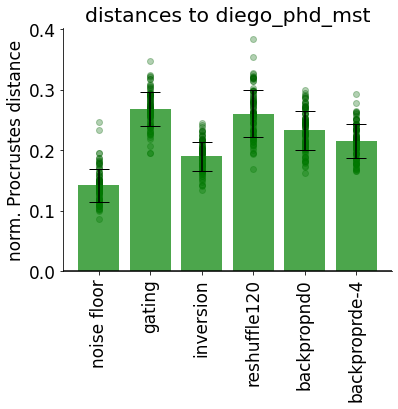

In [426]:
distances_list = [distances_a1a2] + comparison_distances
labels = ['noise floor'] + comparison_networks_names

means = []
errors = []

# Calculate means and standard deviations for each array
for distances in distances_list:
    means.append(np.mean(distances))
    errors.append(np.std(distances))

x = np.arange(len(labels))  # the label locations
width = 0.8  # the width of the bars

fig, ax = plt.subplots(figsize=(6, 6))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})

# Add data points
for i, mean in enumerate(means):
    y_values = distances_list[i]
    ax.scatter([i]*len(y_values), y_values, color='darkgreen', zorder=0, alpha=0.3)

# Create bars with error bars
rects1 = ax.bar(x, means, width, yerr=errors, color="green", alpha=0.7, label='Means', capsize=10)

# Labels and titles
ax.set_ylabel('norm. Procrustes distance')
ax.set_title(f'distances to {neuraldata_name}')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.axhline(0, color='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#ax.legend()

fig.tight_layout()

# Show plot
plt.show()

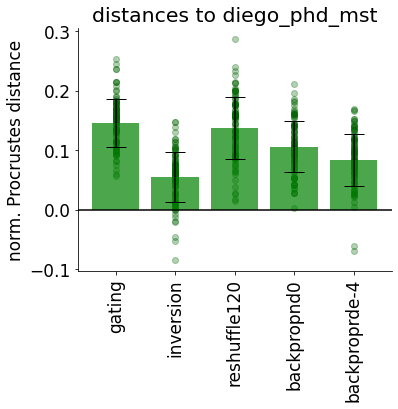

In [427]:
distances_list = [(x-distances_a1a2)/(1-distances_a1a2) for x in comparison_distances]
labels = comparison_networks_names

means = []
errors = []

# Calculate means and standard deviations for each array
for distances in distances_list:
    means.append(np.mean(distances))
    errors.append(np.std(distances))

x = np.arange(len(labels))  # the label locations
width = 0.8  # the width of the bars

fig, ax = plt.subplots(figsize=(6, 6))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})

# Add data points
for i, mean in enumerate(means):
    y_values = distances_list[i]
    ax.scatter([i]*len(y_values), y_values, color='darkgreen', zorder=0, alpha=0.3)

# Create bars with error bars
rects1 = ax.bar(x, means, width, yerr=errors, color="green", alpha=0.7, label='Means', capsize=10)

# Labels and titles
ax.set_ylabel('norm. Procrustes distance')
ax.set_title(f'distances to {neuraldata_name}')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.axhline(0, color='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#ax.legend()

fig.tight_layout()

# Show plot
plt.show()

# Archive

/var/folders/47/5g669ycs2t17c0kkg2_np43m0000gn/T/ipykernel_41394/2719528755.py:13: RuntimeWarning: Mean of empty slice
  dist_ave[i, j] = np.nanmean(temp)


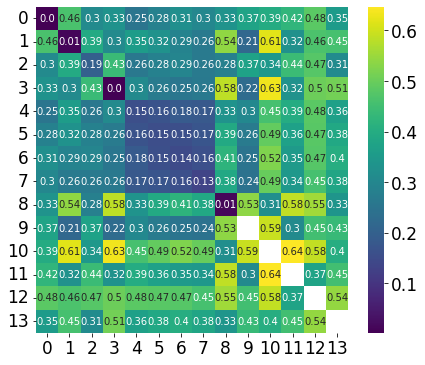

In [194]:
fig = plt.figure(figsize=(7, 6))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
n_networks = len(labels_once)
dist_ave = np.zeros((n_networks, n_networks))
for i in range(n_networks):
    for j in range(n_networks):
        temp = np.copy(dist[list(all_networks.values())[i]['ids'], :][:, list(all_networks.values())[j]['ids']])
        if i==j: 
            for k in range(len(temp)):
                temp[k, k] = None # remove diagonal elemenrs
        #print(i, j, temp)
        #print(list(networks.values())[i]['ids'], list(networks.values())[j]['ids'])
        dist_ave[i, j] = np.nanmean(temp)
ax = sns.heatmap(dist_ave, cmap="viridis", annot=((dist_ave*100).astype(int)/100).astype(str), annot_kws={'fontsize': 10}, fmt='s')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
#plt.xticks(np.linspace(0.5, len(labels_once)-.5, len(labels_once)), labels_once, fontsize=10)
#plt.yticks(np.linspace(0.5, len(labels_once)-.5, len(labels_once)), labels_once, fontsize=10)
#plt.axis('off')
plt.savefig("distancematrix.pdf", bbox_inches = 'tight')